In [1]:
import pandas as pd

# Carica il tuo file CSV
df = pd.read_csv("football_matches_dataset.csv")

# Filtra solo le righe dove la colonna 'league' è "Serie A"
serie_a_df = df[df['league'] == 'Serie A']

# Salva il risultato in un nuovo CSV
serie_a_df.to_csv("serie_a_only.csv", index=False)

print("File salvato come 'serie_a_only.csv'")


File salvato come 'serie_a_only.csv'


In [5]:
import pandas as pd

# 1. Carica CSV originale e filtra solo Serie A
serie_a_df = pd.read_csv("serie_a_only.csv")


def prepare_classification_dataset(df):
    # Colonne utili per il task
    columns_to_keep = [
        "home_team", "away_team",
        "home_score", "away_score",
        "home_standings", "away_standings",
        "season"
    ]

    # Filtra e rimuove righe incomplete
    df = df[columns_to_keep].dropna()

    # Rinomina: home → A, away → B
    df.columns = [col.replace("home_", "A_").replace("away_", "B_") for col in df.columns]

    # A_ è in casa → target = 1
    df["target"] = 1


    return df


# 5. Salva su CSV

serie_a_df = prepare_classification_dataset(serie_a_df)
serie_a_df.drop(serie_a_df[serie_a_df["season"] == "2021/2022"].index, axis=0, inplace=True)
serie_a_df.drop(serie_a_df[serie_a_df["season"] == "2022/2023"].index, axis=0, inplace=True)
serie_a_df.to_csv("clean_serie_a.csv", index=False)
print("File salvato come 'clean_serie_a.csv'")

print("Tutto pronto!")


File salvato come 'clean_serie_a.csv'
Tutto pronto!


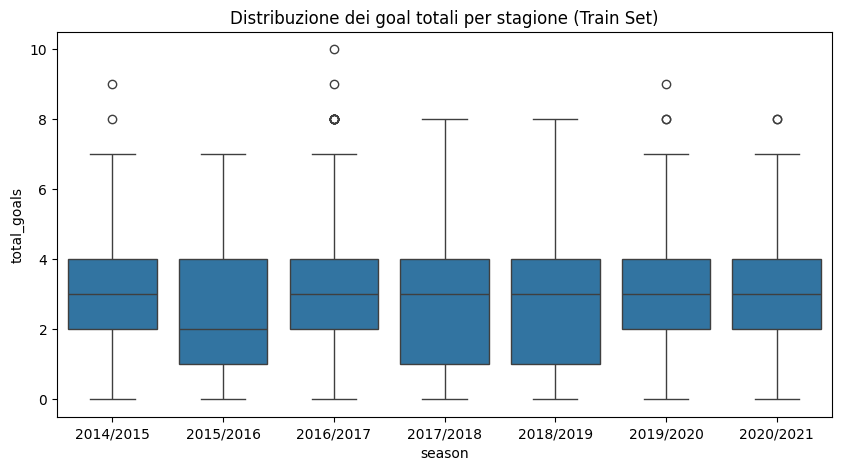

Outlier identificati nel training set: 24 partite


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd

# Carica i dataset già salvati
df = pd.read_csv("clean_serie_a.csv")


# Aggiungiamo una colonna per i goal totali
df["total_goals"] = df["A_score"] + df["B_score"]

# Boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x="season", y="total_goals")
plt.title("Distribuzione dei goal totali per stagione (Train Set)")
plt.show()

# Calcolo outlier per rimozione
Q1 = df["total_goals"].quantile(0.25)
Q3 = df["total_goals"].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

outliers = df[df["total_goals"] > upper_bound]
print(f"Outlier identificati nel training set: {len(outliers)} partite")

In [7]:
import pandas as pd
# Rimozione outlier
df = df[df["total_goals"] <= upper_bound]
df.to_csv("clean_serie_a_no_outliers.csv", index=False)
print("Outlier rimossi e file salvato come 'clean_serie_a_no_outliers.csv'")



Outlier rimossi e file salvato come 'clean_serie_a_no_outliers.csv'


In [12]:
import pandas as pd

# Carichiamo nuovamente il dataset
df = pd.read_csv("clean_serie_a_no_outliers.csv")

# Aggiungiamo un ID di partita per tenere traccia dei match originali
df['match_id'] = df.index

# Versione 1: A_team è casa
df_a_home = df.copy()
df_a_home['target'] = 1

# Versione 2: B_team è casa → invertiamo le colonne
df_b_home = df.copy()
df_b_home['A_team'] = df['B_team']
df_b_home['B_team'] = df['A_team']
df_b_home['A_score'] = df['B_score']
df_b_home['B_score'] = df['A_score']
df_b_home['A_standings'] = df['B_standings']
df_b_home['B_standings'] = df['A_standings']
df_b_home['target'] = 0

# Uniamo i due dataframe per creare un dataset bilanciato
df_balanced = pd.concat([df_a_home, df_b_home], ignore_index=True)

# Calcoliamo le delta-feature (differenze tra A e B)
df_balanced['delta_score'] = df_balanced['A_score'] - df_balanced['B_score']
df_balanced['delta_standings'] = df_balanced['A_standings'] - df_balanced['B_standings']

# Mostriamo i primi record per controllo
df_balanced[['A_team', 'B_team', 'delta_score', 'delta_standings', 'target']].head(10)

# Salviamo il dataset finale
df_balanced.to_csv("balanced_serie_a_dataset.csv", index=False)
print("Dataset bilanciato salvato come 'balanced_serie_a_dataset.csv'")


Dataset bilanciato salvato come 'balanced_serie_a_dataset.csv'


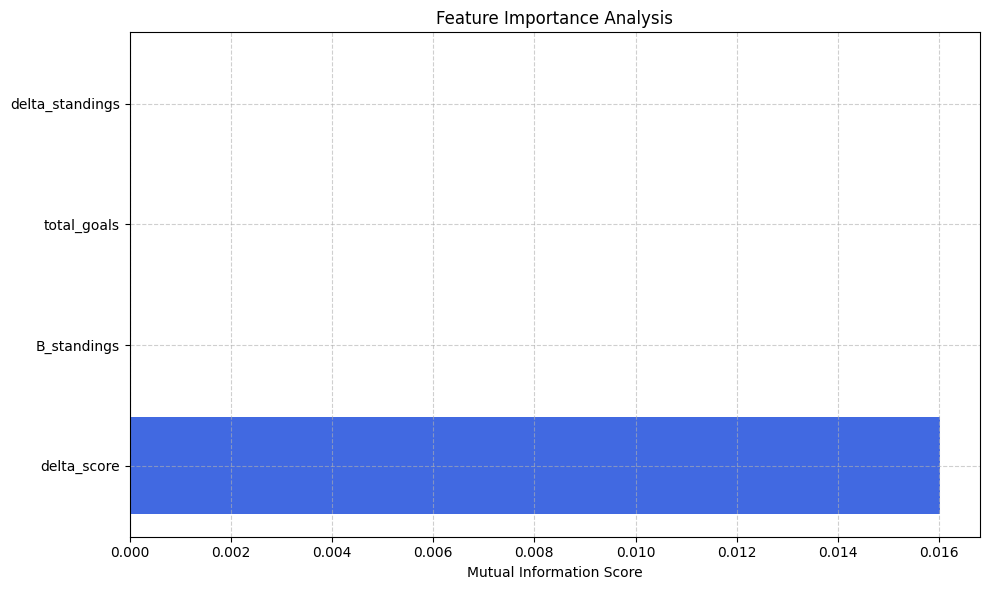

Feature selezionate: ['delta_score']


ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- B_standings
- delta_standings
- total_goals


: 

In [ ]:
# ───────────────────────────────────────────────────────────────────────────────
# 1. Import delle librerie
# ───────────────────────────────────────────────────────────────────────────────
import pandas as pd
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# ───────────────────────────────────────────────────────────────────────────────
# 2. Caricamento e preparazione del dataset
# ───────────────────────────────────────────────────────────────────────────────
df = pd.read_csv('balanced_serie_a_dataset.csv')

# Estraggo l'anno di inizio stagione come intero (es. "2016/2017" → 2016)
df['season_start'] = df['season'].str.split('/').str[0].astype(int)
df.drop(columns=['season'], inplace=True)

# ───────────────────────────────────────────────────────────────────────────────
# 3. Definizione dei set per le stagioni
# ───────────────────────────────────────────────────────────────────────────────
# Train su stagioni dal 2014 al 2018 inclusive
df_train = df[df['season_start'].between(2014, 2018)]

# Test su stagione 2019 (inizio 2019 → stagione 2019/2020)
df_test_2019 = df[df['season_start'] == 2019]

# Hold‑out su stagione 2020 (futuro test)
df_holdout_2020 = df[df['season_start'] == 2020]

# ───────────────────────────────────────────────────────────────────────────────
# 4. Preparo X/y per ognuno dei tre set con un approccio più avanzato
# ───────────────────────────────────────────────────────────────────────────────
def prepare_X_y(df_subset, feature_names=None, scaler=None, selector=None, fit=False):
    """
    Prepara X e y con preprocessing avanzato:
    - Selezione delle feature più importanti
    - Normalizzazione delle feature
    - Gestione coerente delle coppie match_id
    
    Args:
        df_subset: DataFrame con i dati
        feature_names: Lista di feature da usare (se None, usa tutte le numeriche disponibili)
        scaler: StandardScaler pre-addestrato o None
        selector: Feature selector pre-addestrato o None
        fit: Se True, addestra scaler e selector, altrimenti li usa solo per trasformare
        
    Returns:
        X, y, scaler, selector, feature_names_selected
    """
    # Se non vengono specificate feature, usa tutte quelle numeriche disponibili
    if feature_names is None:
        # Seleziona tutte le colonne numeriche escludendo target, match_id e informazioni non predittive
        exclude_cols = ['target', 'match_id', 'A_team', 'B_team', 'season_start', 'B_steandings', 'A_standings', 'A_score', 'B_score', ]
        feature_names = [col for col in df_subset.columns if col not in exclude_cols 
                        and df_subset[col].dtype in ['int64', 'float64']]
    
    # Seleziona le feature di base
    X = df_subset[feature_names].copy()
    y = df_subset['target'].values
    
    # Se siamo in fase di training, fittiamo il scaler e il selector
    if fit:
        # Normalizzazione delle feature
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Selezione delle feature più importanti
        selector = SelectKBest(mutual_info_classif, k='all')
        selector.fit(X_scaled, y)
        
        # Identifica le feature più importanti (almeno 0.01 di importanza)
        threshold = 0.01
        feature_mask = selector.scores_ > threshold
        selected_features = [feature_names[i] for i in range(len(feature_names)) if feature_mask[i]]
        
        # Se nessuna feature supera la soglia, prendi le top 3
        if len(selected_features) == 0:
            top_n = min(3, len(feature_names))
            top_indices = np.argsort(selector.scores_)[-top_n:]
            selected_features = [feature_names[i] for i in top_indices]
        
        # Visualizza le importanze delle feature
        plt.figure(figsize=(10, 6))
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': selector.scores_
        }).sort_values('Importance', ascending=False)
        
        plt.barh(importance_df['Feature'], importance_df['Importance'], color='royalblue')
        plt.xlabel('Mutual Information Score')
        plt.title('Feature Importance Analysis')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()
        
        print("Feature selezionate:", selected_features)
        
        # Aggiorna X con le feature selezionate
        X = X[selected_features]
        
        return X.values, y, scaler, selector, selected_features
    else:
        # Se non siamo in training, applichiamo scaler e selector esistenti
        if scaler is not None:
            X_scaled = scaler.transform(X)
        else:
            X_scaled = X.values
            
        # Se abbiamo un selector, usiamo le feature che ha selezionato
        if selector is not None and feature_names is not None:
            # Identifica le feature più importanti (almeno 0.01 di importanza)
            threshold = 0.01
            feature_mask = selector.scores_ > threshold
            selected_features = [feature_names[i] for i in range(len(feature_names)) if feature_mask[i]]
            
            # Se nessuna feature supera la soglia, prendi le top 3
            if len(selected_features) == 0:
                top_n = min(3, len(feature_names))
                top_indices = np.argsort(selector.scores_)[-top_n:]
                selected_features = [feature_names[i] for i in top_indices]
                
            # Restringi X alle feature selezionate
            X = X[selected_features].values
        else:
            X = X_scaled
            selected_features = feature_names
            
        return X, y, None, None, selected_features

# Utilizzo con addestramento sul training set
X_train, y_train, scaler, selector, selected_features = prepare_X_y(df_train, fit=True)

# Utilizzo sui set di test e holdout
X_test_2019, y_test_2019, _, _, _ = prepare_X_y(
    df_test_2019, 
    feature_names=selected_features, 
    scaler=scaler,
    selector=selector
)

X_holdout_2020, y_holdout_2020, _, _, _ = prepare_X_y(
    df_holdout_2020,
    feature_names=selected_features,
    scaler=scaler,
    selector=selector
)

# ───────────────────────────────────────────────────────────────────────────────
# 5. Training con AdaBoost e Grid Search
# ───────────────────────────────────────────────────────────────────────────────
# Base model
base_model = DecisionTreeClassifier(max_depth=1, random_state=42)

# Parametri da testare
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5, 1.0]
}

# Setup GridSearch
grid_search = GridSearchCV(
    AdaBoostClassifier(estimator=base_model, random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,  # Usa tutti i core disponibili
    verbose=1
)

# Fit su training set
grid_search.fit(X_train, y_train)

# Miglior modello
best_model = grid_search.best_estimator_
print(f"Migliori parametri: {grid_search.best_params_}")

# ───────────────────────────────────────────────────────────────────────────────
# 6. Visualizza importanza delle feature sul modello finale
# ───────────────────────────────────────────────────────────────────────────────
importances = best_model.feature_importances_

# Stampa tabellare
for name, importance in zip(selected_features, importances):
    print(f"{name}: {importance:.3f}")

# Visualizzazione grafica
plt.figure(figsize=(8, 5))
plt.barh(selected_features, importances, color='forestgreen')
plt.xlabel("Importanza")
plt.title("Feature Importances - AdaBoost Model")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# ───────────────────────────────────────────────────────────────────────────────
# 7. Valutazione sui due set
# ───────────────────────────────────────────────────────────────────────────────
def evaluate(model, X, y, label):
    y_pred = model.predict(X)
    print(f"\n--- Risultati su {label} ---")
    print(f"Accuracy: {accuracy_score(y, y_pred):.3f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y, y_pred))
    print("\nClassification Report:")
    print(classification_report(y, y_pred))
    
    # Visualizza matrice di confusione
    plt.figure(figsize=(6, 5))
    cm = confusion_matrix(y, y_pred)
    plt.imshow(cm, cmap='Blues')
    plt.title(f'Matrice di Confusione - {label}')
    plt.colorbar()
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # Aggiungi le etichette ai valori
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    classes = ["Away", "Home"]
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.show()

# Valuto su test 2019
evaluate(best_model, X_test_2019, y_test_2019, 'Test 2019')

# Valuto su hold‑out 2020
evaluate(best_model, X_holdout_2020, y_holdout_2020, 'Hold‑out 2020')